In [1]:
import os
import sys
import numpy as np
import json

sys.path.append('..')
from configs.arguments import get_config_dict
# data_root = '/root/data'
from utils.multiview_utils import Camera, Calibration, MultiviewVids
from utils.io_utils import write_json, load_json
from utils.metadata_utils import get_cam_names
from utils.coordinate_utils import update_reconstruction, point_in_polygon, project_to_ground_plane_cv2
from utils.plot_utils import rotation_matrix, perp

from scipy.spatial.transform import Rotation as R
from skspatial.objects import Point, Vector, Plane, Points, Line
import pyransac3d as pyrsc

import copy
import cv2
import ipywidgets as widgets
import ipympl
import matplotlib.pyplot as plt
%matplotlib widget
#ipympl
# %matplotlib inline
# from scipy import *

# from skspatial.plotting import plot_3d

arv_copy = sys.argv
sys.argv = ['pop']
sys.argv.append('-cfg')
config_path = os.path.abspath('../../project_config.yaml')
sys.argv.append(config_path)#('/root/project_config.yaml')
sys.argv.append('-dr')
root_path = os.path.abspath('../../data/')
sys.argv.append(root_path)#('/root/data')
sys.argv.append('-l')
sys.argv.append('info')

# load arguments from the arg parser
config = get_config_dict()
data_root = config["main"]["data_root"] #"/Users/sarno/Desktop/Pomelo/data"#
calib_dir = os.path.join(data_root, '0-calibration', 'calibs')
video_dir = os.path.join(data_root, 'raw_data', 'footage')
reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'reconstruction.json')
omni_tag = '360'
# assert os.path.exists(reconstruction_dir), "Reconstruction not found. Please run 0-calibration/2-extrinsics.py first."


reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction.json')
if not os.path.exists(reconstruction_dir):
    print( "Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.")
    

In [2]:
mvvids = MultiviewVids(newest=False)

max_frame = np.min([60, mvvids.get_max_frame_id() - 1])
step = 30
base_frames = {}

first_frame = {
  "cam1": 0,
  "cam2": 0,
  "cam3": 0,
  "cam4": 0
}

mvvids.set_first_frames(first_frame)
frame_ids = list(np.arange(0, max_frame, step))

base_frames = mvvids.extract_mv(frame_ids, undistort = True)

# Load reconstruction
reconstruction = load_json(reconstruction_dir)[0]

10:50:00.394 - [...bration/../utils/multiview_utils.py:832] - INFO     - Cameras: ['cam1', 'cam2', 'cam3', 'cam4']
10:50:00.619 - [...bration/../utils/multiview_utils.py:840] - INFO     - Loading calibration data for camera 'cam1'
10:50:00.788 - [...bration/../utils/multiview_utils.py:840] - INFO     - Loading calibration data for camera 'cam2'
10:50:00.951 - [...bration/../utils/multiview_utils.py:840] - INFO     - Loading calibration data for camera 'cam3'
10:50:01.136 - [...bration/../utils/multiview_utils.py:840] - INFO     - Loading calibration data for camera 'cam4'
10:50:01.204 - [...bration/../utils/multiview_utils.py:265] - INFO     - Extracting frame 0 from cam1...
10:50:01.869 - [...bration/../utils/multiview_utils.py:265] - INFO     - Extracting frame 0 from cam2...
10:50:02.463 - [...bration/../utils/multiview_utils.py:204] - WARNING  - Failed to load frame 30 after 10 attempts
10:50:02.467 - [...bration/../utils/multiview_utils.py:282] - WARNING  - Frame 30 same as the pr

In [3]:
# setting the first frame for each camera
# we display a frame for camera 1 and then we ask the user to select the corresponding frame for the other cameras
# we do this because the cameras are not perfectly synchronised
from utils.plot_utils import first_frame_selector
json_path = os.path.join(data_root, '0-calibration', 'first_frame.json')

first_frame_selector(mvvids.cams, frame_ids, base_frames, json_path)



interactive(children=(Dropdown(description='Camera:', options=('cam2', 'cam3', 'cam4'), value='cam2'), IntSlid…

Dropdown(description='Camera:', options=('cam1', 'cam2', 'cam3', 'cam4'), value='cam1')

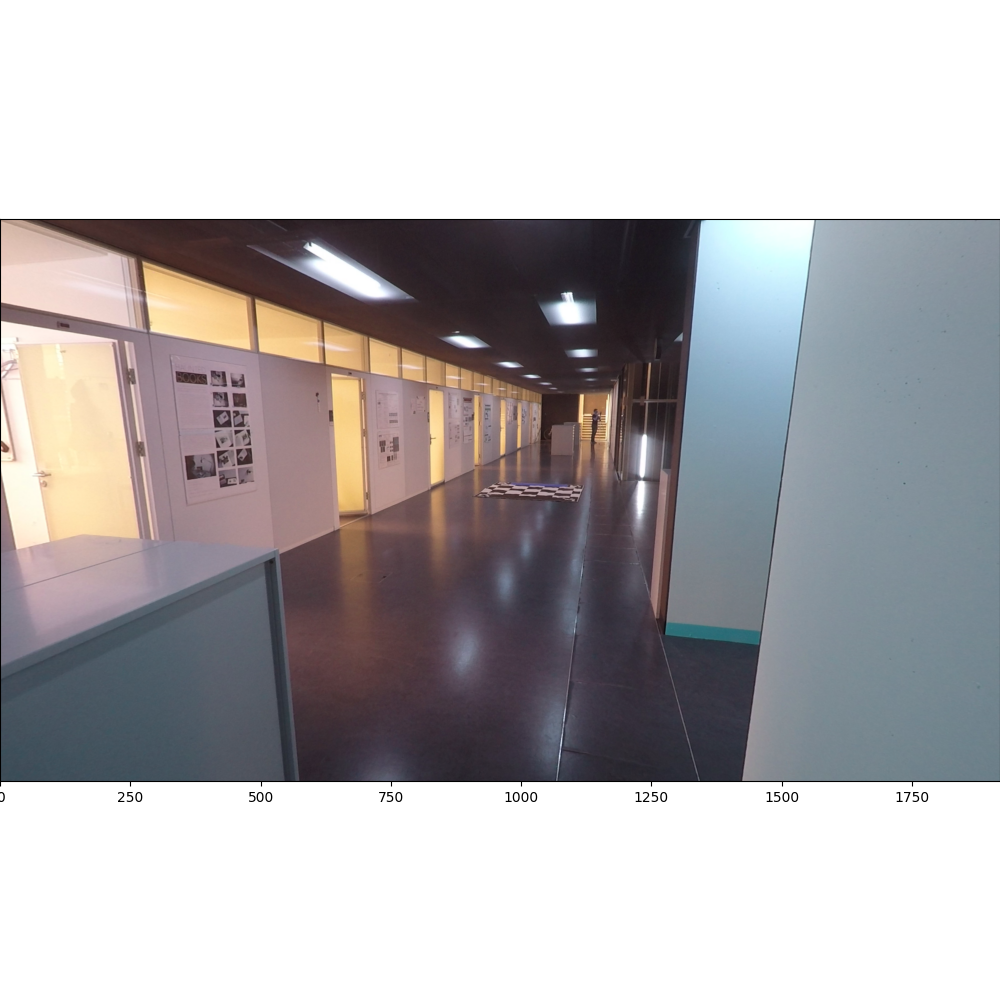

In [5]:
plt.close('all')

from matplotlib.patches import Polygon


roi_points = {cam.name: [] for cam in mvvids.cams}

# create dropdown widget with camera names as options
cam_dropdown = widgets.Dropdown(
    options=[cam.name for cam in mvvids.cams],
    value=mvvids.cams[0].name,
    description='Camera:',
    disabled=False,
)

def onclick(event, cam):
    ax.plot(event.xdata, event.ydata, 'rx', markersize=10)
    roi_points[cam.name].append(([event.xdata, event.ydata]))

    # check if we have at least 3 points to define a polygon
    if len(roi_points[cam.name]) >= 3:
        # get the x and y coordinates of the clicked points
        x, y = zip(*roi_points[cam.name])

        # create a polygon patch with the clicked points
        polygon = Polygon(list(zip(x, y)), alpha=0.2, facecolor='C0')

        # remove any existing polygon patches from the axes
        for patch in ax.patches:
            patch.remove()

        # add the new polygon patch to the axes
        ax.add_patch(polygon)

    fig.canvas.draw()
    pass

def update_cam(change):
    ax.cla()
    global cam
    cam_name = change.new
    cam = next(cam for cam in mvvids.cams if cam.name == cam_name)
    ax.set_title(f"Camera: {cam.name}")
    ax.imshow(base_frames[cam.name][0])
    fig.canvas.draw()
    pass

cam_dropdown.observe(update_cam, names='value')

cam = mvvids.cams[0]
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(base_frames[cam.name][0])
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

cid = fig.canvas.mpl_connect('button_press_event', lambda event: onclick(event, cam))

display(cam_dropdown)
# display(fig)

In [5]:
roi_points = {'cam1': [[529.708046875, 650.7000390625001],
  [556.588046875, 1071.1800390625],
  [1322.668046875, 1071.1800390625],
  [1161.388046875, 458.7000390625001],
  [1011.6280468750001, 441.4200390625001]],
 'cam2': [[902.188046875, 473.10000976562515],
  [748.588046875, 1068.300009765625],
  [1322.668046875, 1070.2200097656253],
  [1266.988046875, 995.3400097656252],
  [1307.308046875, 601.7400097656251],
  [1026.988046875, 463.500009765625]],
 'cam3': [[508.58804687500003, 769.7400390625],
  [512.4280468750001, 1063.5000390625003],
  [1217.068046875, 1076.9400390625],
  [1053.868046875, 587.3400390625001],
  [930.988046875, 587.3400390625001]],
 'cam4': [[712.108046875, 532.6200390625002],
  [535.468046875, 1072.1400390625],
  [1307.308046875, 1070.2200390625],
  [1307.308046875, 638.2200390625002],
  [1182.508046875, 569.1000390625002],
  [1005.868046875, 586.3800390625],
  [858.0280468750001, 524.9400390625001]]}

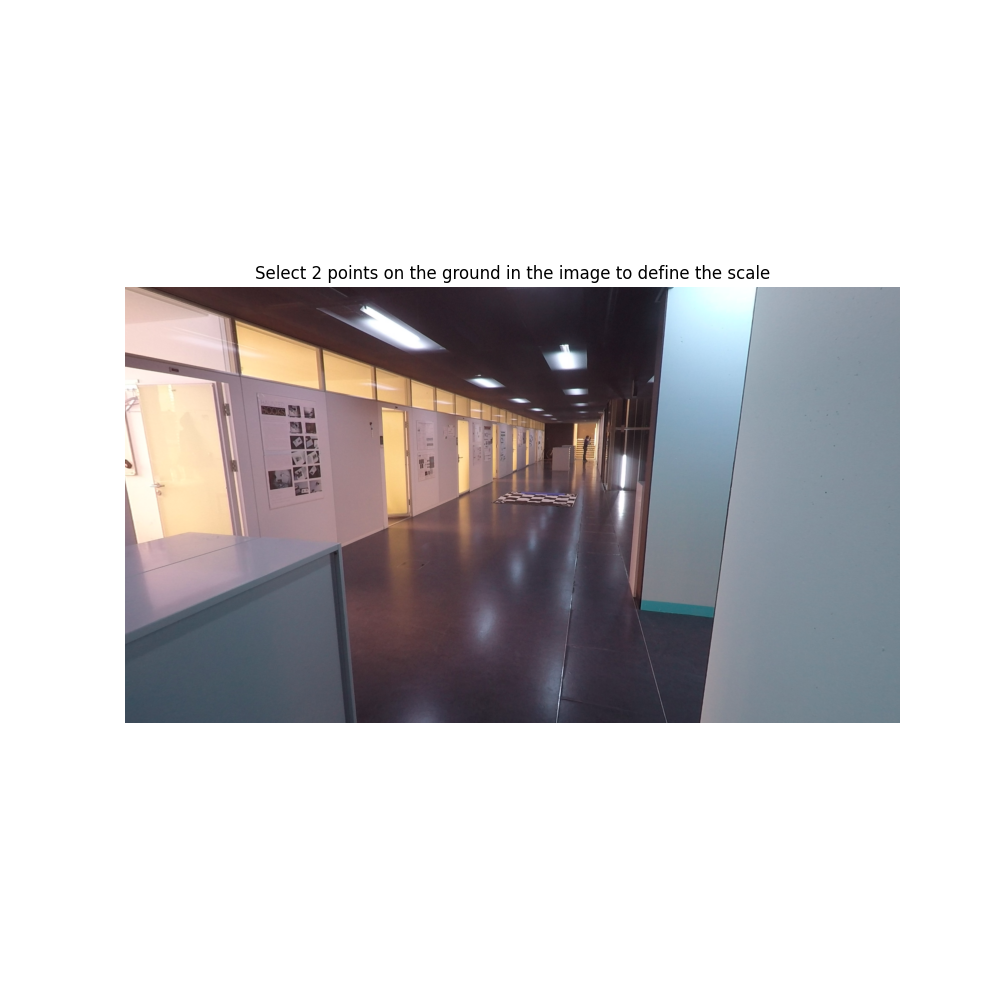

In [6]:
# Select 2 points on the ground in the image to define the scale

known_distance = 40.0 # distance between two points in cm

cam = mvvids.cams[0]
frame_num = len(base_frames[cam.name]) - 1
img = copy.deepcopy(base_frames[cam.name][frame_num])

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title(f"Select 2 points on the ground in the image to define the scale")
ax.imshow(img)
ax.axis('off')

cam_center = cam.get_position()
first_point = None
second_point = None
scale_info = {}
distance = known_distance
def onclick3(event):
    global first_point
    global second_point
    global distance
    global scale_info
    x, y = event.xdata, event.ydata
    # img = cv2.drawMarker(img1, (int(x), int(y)), (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)

    if first_point is None:
        # find the 3D point on the ground plane
        first_point = (x, y)
        ax.plot(x, y, 'rx')
    elif second_point is None:
        second_point = (x, y)
        ax.plot(x, y, 'bx')
    
    scale_info = {'id': cam.calibration.view_id,'distance': known_distance, 
              'point1': first_point, 'point2': second_point}

    ax.imshow(img)
    fig.canvas.draw()



cid = fig.canvas.mpl_connect('button_press_event', onclick3)

In [7]:
scale_info = {'id': '1',
 'distance': 40.0,
 'point1': (1094.5193548387097, 886.3387096774193),
 'point2': (1287.758064516129, 916.0677419354838)}

In [8]:
scale_info

{'id': '1',
 'distance': 40.0,
 'point1': (1094.5193548387097, 886.3387096774193),
 'point2': (1287.758064516129, 916.0677419354838)}

In [7]:
from utils.plot_utils import align_ground

# set ROI for the cameras
for cam in mvvids.cams:
    cam.calibration = cam.calibration._replace(ROI = roi_points[cam.name])

origin, rotation, scale, ground_plane, translated_gpp, pyrsc_plane = align_ground(mvvids, reconstruction, scale_info)



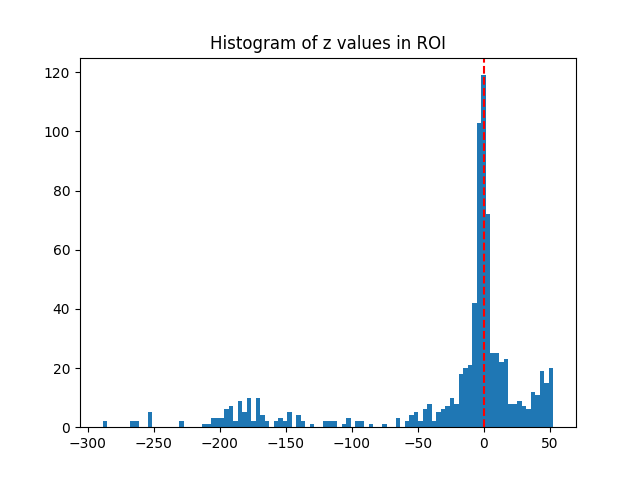

In [8]:
# display z histogram
new_z_list = translated_gpp[:,2]

# remove outliers top and bottom 1%
new_z_list = sorted(new_z_list)
new_z_list = new_z_list[int(len(new_z_list)*0.02):int(len(new_z_list)*0.90)]

fig, ax = plt.subplots()

ax.clear()
ax.hist(new_z_list, bins=100, range=(min(new_z_list), max(new_z_list)))
# ax.plot(translated_gpp[pyrsc_plane.inliers][:,2], [1 for i in range(len(pyrsc_plane.inliers))], 'rx' )
ax.set_title("Histogram of z values in ROI")
# Draw a vertical line at 0
ax.axvline(0, color="red", linestyle="--")

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

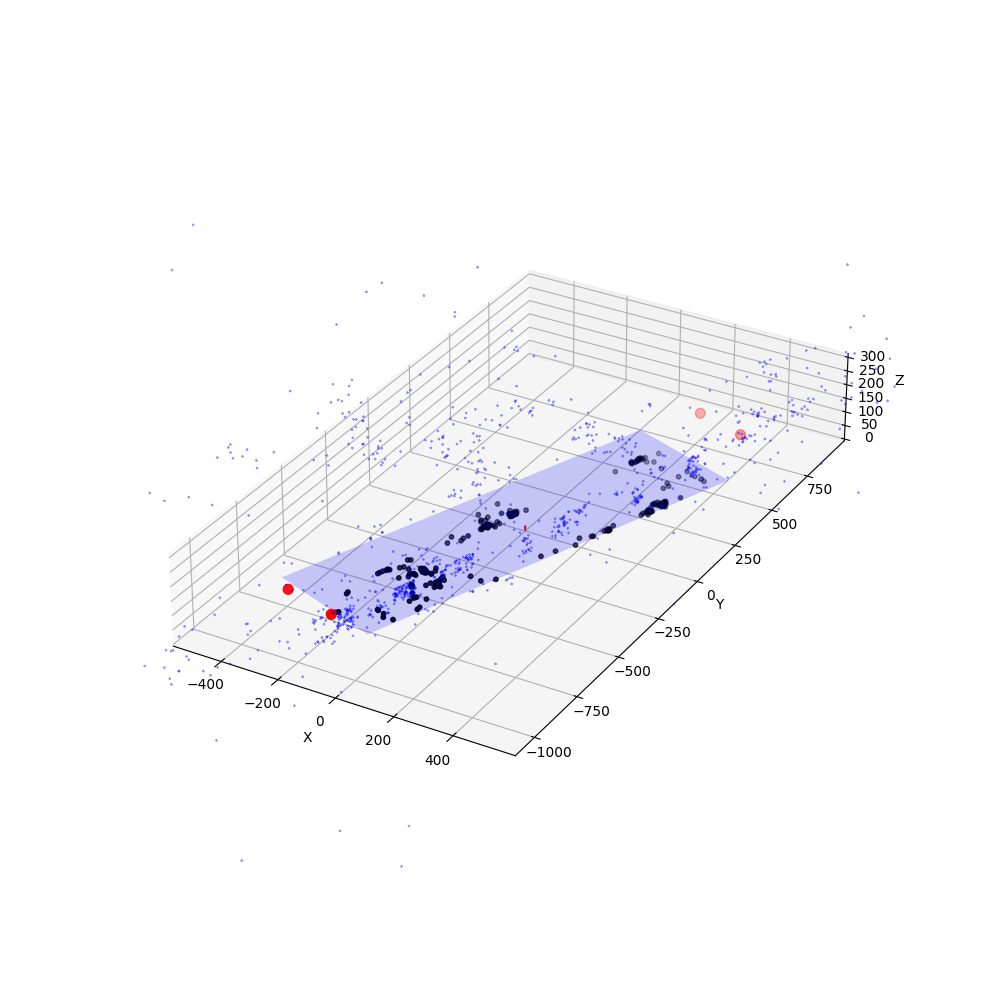

In [9]:
from utils.plot_utils import plot_3d_reconstruction


# update the reconstruction with the new origin
temp_reconstruction = update_reconstruction(reconstruction, 
                                            rotation = rotation, 
                                            origin=origin,
                                            scaling=scale)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

plot_mvvids = copy.deepcopy(mvvids)
for cam in plot_mvvids.cams:
    cam.calibration = cam.calib_from_reconstruction(reconstruction = temp_reconstruction)

plot_3d_reconstruction(ax, temp_reconstruction, mvvids,  
                           ground_plane= ground_plane, 
                           inliers = Points(translated_gpp[pyrsc_plane.inliers]), 
                           num_samples = 1000)


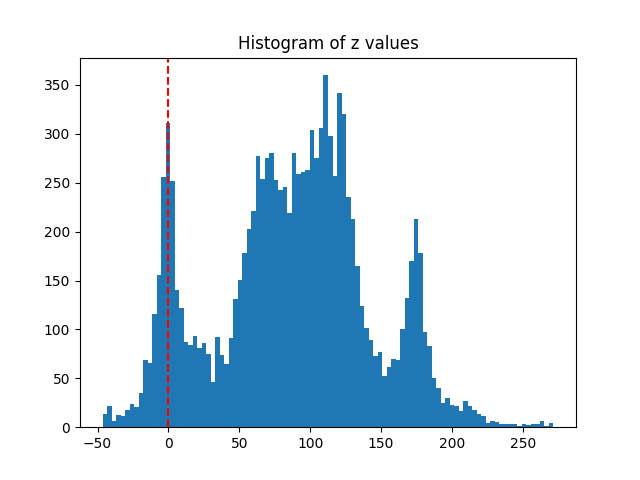

In [10]:
# display z histogram
new_z_list = []

for i in temp_reconstruction['points'].keys():
    new_z_list.append(temp_reconstruction['points'][i]['coordinates'][2])

# remove outliers top and bottom 1%
new_z_list = sorted(new_z_list)
new_z_list = new_z_list[int(len(new_z_list)*0.02):int(len(new_z_list)*0.98)]

fig, ax = plt.subplots()

ax.clear()
ax.hist(new_z_list, bins=100, range=(min(new_z_list), max(new_z_list)))
ax.set_title("Histogram of z values")
# Draw a vertical line at 0
ax.axvline(0, color="red", linestyle="--")

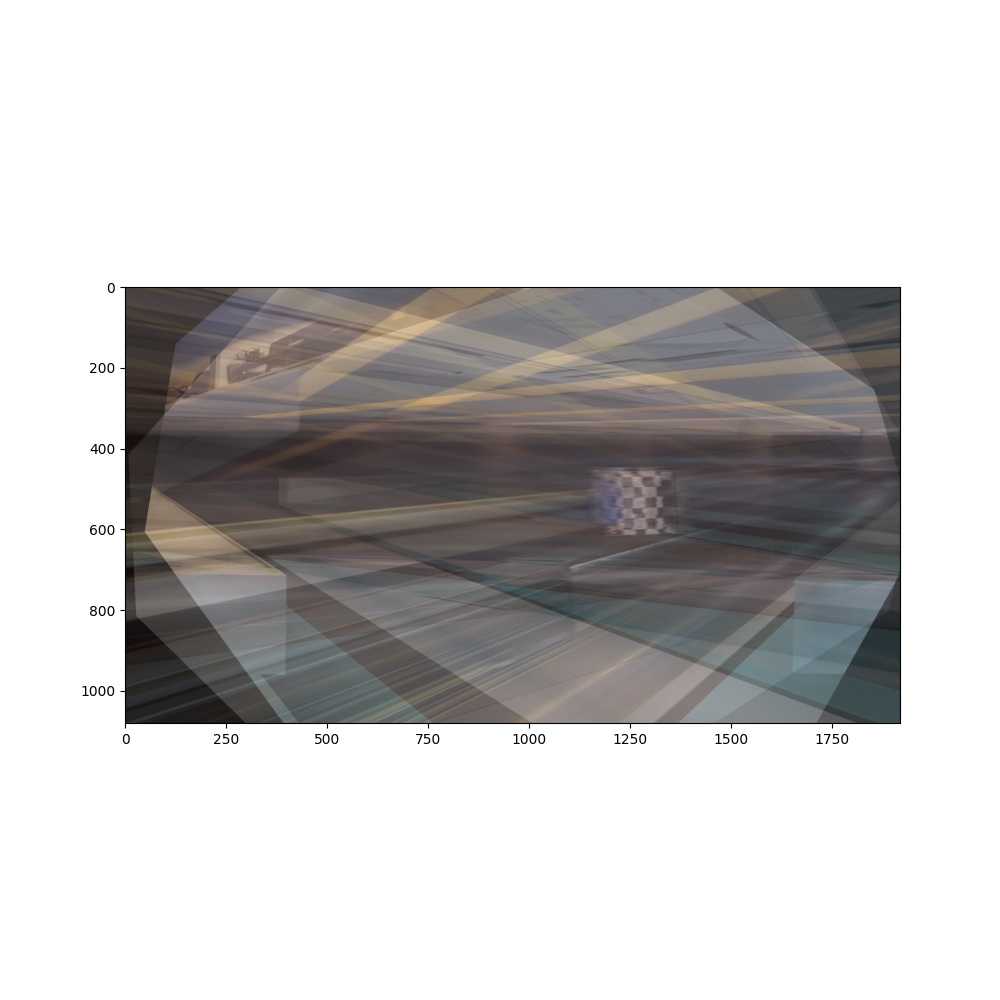

In [11]:
plt.clf()

fig, ax = plt.subplots(figsize=(10,10))
alphas = [1.0, 0.7, 0.5,0.3]

temp_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation, origin=origin, scaling = scale)

rect, _ = mvvids.get_bounding_box(reconstruction = temp_reconstruction)
output_img_size = (1920, 1080)
input_img_size = (1920, 1080) # (1920*2, 1080*2)

for_reproj_error = None
for cam in mvvids.cams:
    img = copy.deepcopy(base_frames[cam.name][0])
    # rescale image to 250x180
    img = cv2.resize(img, input_img_size)
    cam.calib_from_reconstruction(reconstruction = temp_reconstruction)
    H = cam.get_ground_plane_homography(input_img_size=input_img_size, output_img_size = output_img_size, bounding_box = rect)
    new_img = project_to_ground_plane_cv2(img, H, (output_img_size[1], output_img_size[0]))
    for_reproj_error = new_img
    # new_img = cv2.warpPerspective(img, np.linalg.inv(H), (output_size[0], output_size[1]))
    ax.imshow(new_img, alpha = alphas[int(cam.calibration.view_id) - 1])


In [12]:
from pathlib import Path
# Save updated reconstruction
new_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation, origin=origin, scaling = scale)
new_reconstruction_path = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction_new.json')
write_json(new_reconstruction_path, [new_reconstruction])

# Save updated calibrations
for camera in mvvids.cams:
    print(f"Saving calibration data for camera: {camera.name}")
    camera.calib_from_reconstruction(reconstruction = new_reconstruction)
    camera.calib_path =  Path(data_root) / '0-calibration' / 'calibs' / f'{camera.name}_new.json'
    camera.calibration = camera.calibration._replace(ROI = roi_points[camera.name])
    camera.calibration = camera.calibration._replace(bounding_box = rect)
    camera.save_calibration(calibration = camera.calibration)

Saving calibration data for camera: cam1
Saving calibration data for camera: cam2
Saving calibration data for camera: cam3
Saving calibration data for camera: cam4
